# 国债期货策略研究

In [2]:
pip install prettytable

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
import datetime
import statsmodels.api as sm
import scipy
from tqdm import tqdm_notebook 
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from statsmodels import api as stm 
from statsmodels import tools
from scipy.optimize import minimize
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import prettytable as pt
from numpy import random
import gc 
import psutil
import os
plt.style.use("seaborn")
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
%config InlineBackend.figure_format='retina'
%matplotlib inline

import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV

## 数据预处理

In [5]:
day_number = 18*3
year = [15,16,17,18,19,20,21]*4
year = sorted(year)
month = ['03','06','09','12']*7
file_name = ['T'+str(x)+y + '.CCFX.xlsx' for x,y in zip(year,month)]
#print('内存使用占比：',psutil.Process(os.getpid()).memory_info().rss/info.total)
def draw_data(raw_data):
    data = raw_data[['close','volume']]#我们只使用收盘价和成交量两个数据
    data.iloc[:,1] = data.iloc[:,1].rolling(15).sum()#价格用该时间点的价格即可，成交量要算求和,这里假设用的是15min来进行slice
    data=data[data.index.minute.isin([1,16,31,46])] 
    data['close'] = data['close'].pct_change()
    return data

def get_return_flow(future1,future2):
    #输入两个期货价格的dataframe，需注意future1是已有的序列，future2是要加入的序列
    nn = pd.concat([future1,future2],axis=1)
    #当过去1天的下一期期货成交量超过上一期的，定义为主力合约的切换
    index = nn[(nn.iloc[:,1].rolling(day_number).sum()<nn.iloc[:,3].rolling(day_number).sum()).values].index[1]
    print("合约切换时间：",index)
    result = pd.concat([future1.loc[:index].iloc[:-1],future2.loc[index:]],axis=0)
    return result

initial =1
for name in file_name:
    print("处理文件"+name)
    #print('内存使用占比：',psutil.Process(os.getpid()).memory_info().rss/info.total)
    try:
        file_location = './data_minute/'+name
        raw_data = pd.read_excel(file_location,index_col=0 )
    except:
        continue
        
    if initial==1:
        initial =0
        future1 = draw_data(raw_data)
        del raw_data
        gc.collect()
        continue
        
    future2 = draw_data(raw_data)
    try:
        future1 = get_return_flow(future1,future2)
    except:
        print("数据整合结束")
        break
    del future2, raw_data
    gc.collect()
future1.iloc[0,0] = 0
future_return = future1.loc[future1.index[1]:future1[(future1.iloc[:,1]>0).values].index[-1]]
future_return.columns = ['价格变动','成交量']
future_price = future_return.copy()
future_price.iloc[:,0] = (future_price.iloc[:,0]+1).cumprod()
future_price.columns = ['价格','成交量']

处理文件T1503.CCFX.xlsx
处理文件T1506.CCFX.xlsx
处理文件T1509.CCFX.xlsx
处理文件T1512.CCFX.xlsx
合约切换时间： 2015-08-14 11:16:00
处理文件T1603.CCFX.xlsx
合约切换时间： 2015-11-24 10:46:00
处理文件T1606.CCFX.xlsx
合约切换时间： 2016-02-18 11:16:00
处理文件T1609.CCFX.xlsx
合约切换时间： 2016-05-10 10:16:00
处理文件T1612.CCFX.xlsx
合约切换时间： 2016-08-11 14:01:00
处理文件T1703.CCFX.xlsx
合约切换时间： 2016-11-10 14:31:00
处理文件T1706.CCFX.xlsx
合约切换时间： 2017-01-25 10:01:00
处理文件T1709.CCFX.xlsx
合约切换时间： 2017-05-11 13:46:00
处理文件T1712.CCFX.xlsx
合约切换时间： 2017-08-10 10:16:00
处理文件T1803.CCFX.xlsx
合约切换时间： 2017-11-13 10:31:00
处理文件T1806.CCFX.xlsx
合约切换时间： 2018-02-12 11:01:00
处理文件T1809.CCFX.xlsx
合约切换时间： 2018-05-21 10:46:00
处理文件T1812.CCFX.xlsx
合约切换时间： 2018-08-16 13:31:00
处理文件T1903.CCFX.xlsx
合约切换时间： 2018-11-19 13:31:00
处理文件T1906.CCFX.xlsx
合约切换时间： 2019-02-21 14:16:00
处理文件T1909.CCFX.xlsx
合约切换时间： 2019-05-22 10:01:00
处理文件T1912.CCFX.xlsx
合约切换时间： 2019-08-15 13:31:00
处理文件T2003.CCFX.xlsx
合约切换时间： 2019-11-20 13:01:00
处理文件T2006.CCFX.xlsx
合约切换时间： 2020-02-19 10:01:00
处理文件T2009.CCFX.xlsx
合约切换时间： 

## 信号产生

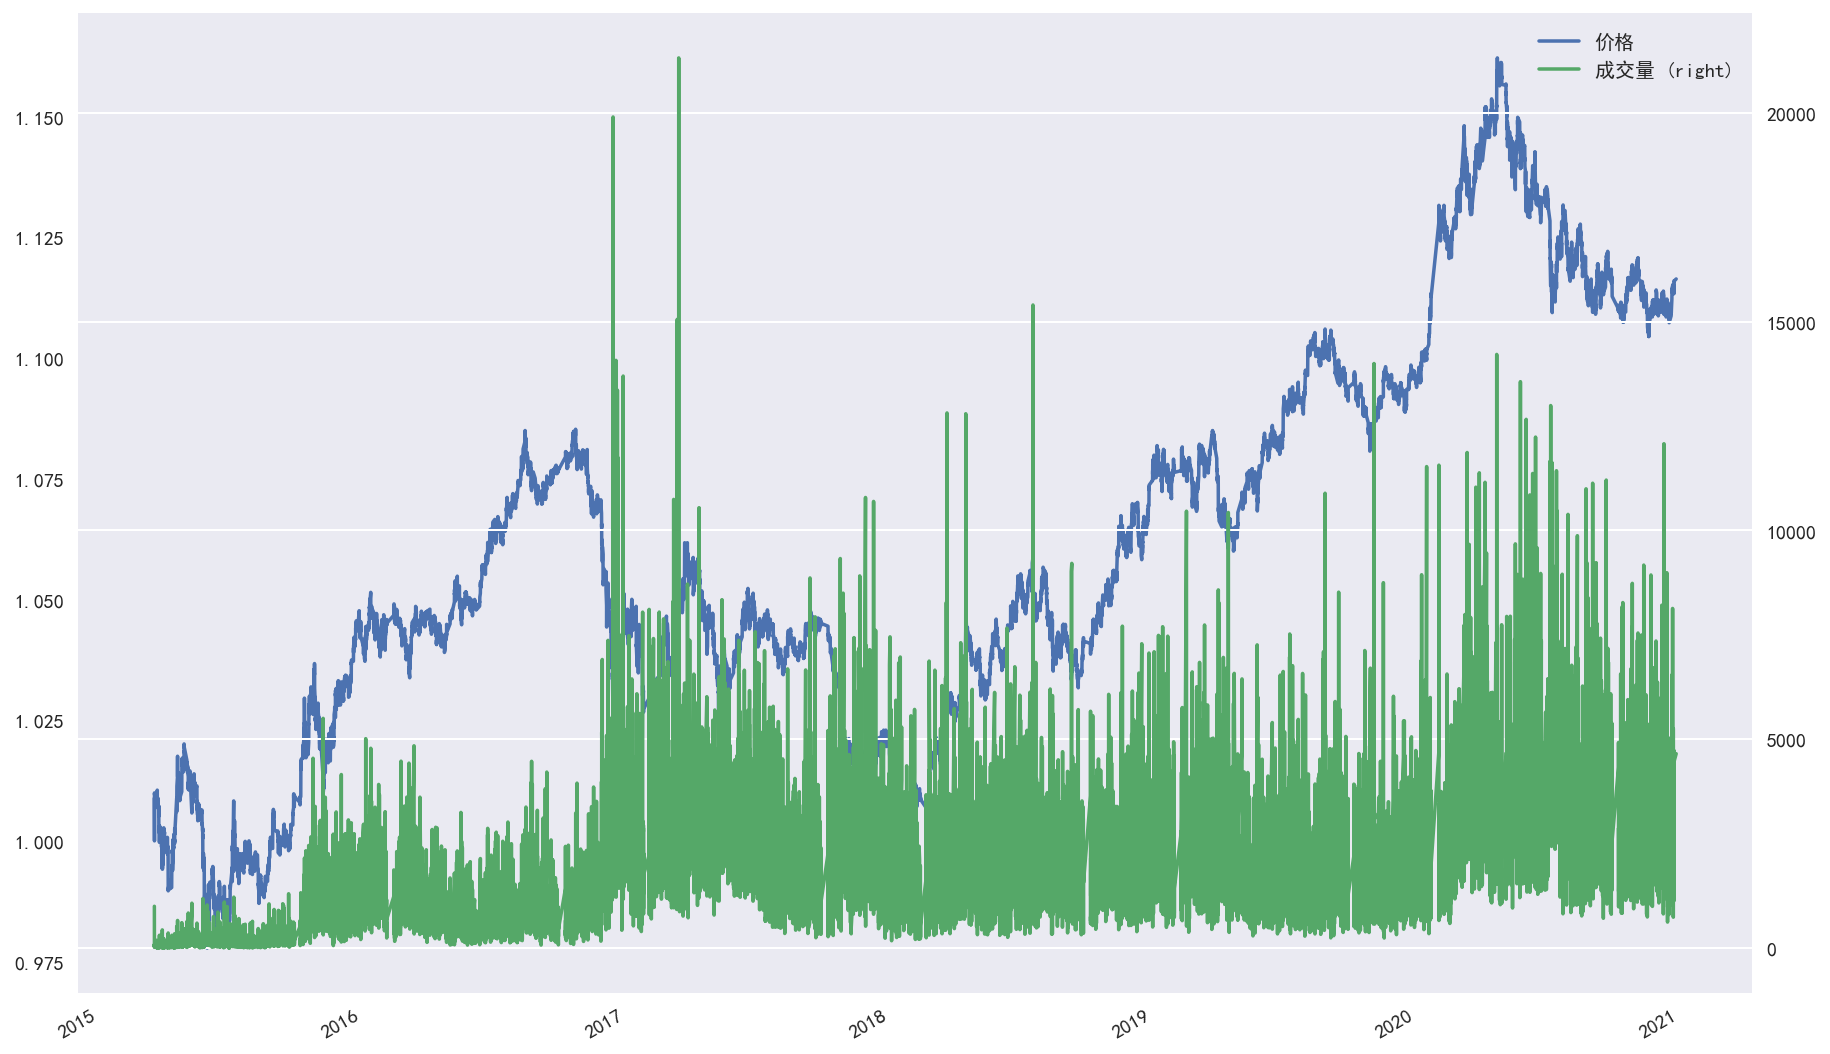

In [6]:
future_price.plot(figsize=(15,10),secondary_y = ["成交量"])

In [7]:
#定义趋势项，当中长期有比较明显的趋势时，增加开仓时间长度
up_trend = future_price.pct_change(int(20*4.5*4))["价格"]>0.02
down_trend = future_price.pct_change(int(20*4.5*4))["价格"]<-0.02
trend = pd.DataFrame(pd.concat([up_trend*1,down_trend*(-1)],axis=1).sum(axis=1))
trend.columns = ["趋势"]

#价格和成交量的均线
price_ave = pd.DataFrame(future_price.iloc[:,0].rolling(int(4.5*4*5)).mean())
price_ave.columns =["价格均线"]
volume_ave = pd.DataFrame(future_price.iloc[:,1].rolling(int(4.5*4*5)).mean())
volume_ave.columns = ["成交量均线"]


all_data = pd.concat([future_price, price_ave,volume_ave,future_return['价格变动'],trend ],axis=1).dropna()
#开仓信号，这里的信号定义的是当前时间段收盘时是否应该开仓
signal_data = pd.DataFrame(np.zeros(len(all_data)),index = all_data.index)
#记录该时间段内的仓位
position_data = pd.DataFrame(np.zeros(len(all_data)),index = all_data.index)


#判断价格是否完成突破
diff = all_data.iloc[:,0]-all_data.iloc[:,2]
break_point1 = (diff.values *np.append(0,diff[:-1].values)<0)
break_point2 = (diff.values *np.append(np.zeros(2),diff[:-2].values)<0)
break_point3 = (diff.values *np.append(np.zeros(3),diff[:-3].values)<0)
break_point =  break_point1+break_point2+break_point3

#判断当期成交量是否够大
volume_break = all_data.iloc[:,1].rolling(1).sum()/all_data.iloc[:,3].rolling(1).sum()

#突破量够大，成交量够大则给出开仓信号
signal_data[break_point*(diff>0.0002).values*(volume_break>1.5).values] = 1
signal_data[break_point*(diff<-0.0005).values*(volume_break>1.5).values]= -1


i =0
open_length = 25 #假设一般情况下开仓一天
cum_return=0 #记录单次开仓的累计回报，用来止盈/止损
position_number=100 
stop_win = 0.01 #止盈
cut_loss = -0.005 #止损

while i < len(all_data):
    
    if position_number<open_length: #判断当天是否需要开仓
        position_data.iloc[i] = p
        discounted_ratio = p*all_data.iloc[i,5]>0
        position_number = position_number+1/(1+discounted_ratio)
        cum_return = cum_return+all_data.iloc[i,4]
        
    if (cum_return>stop_win) or (cum_return<cut_loss):#判断是否需要止盈/止损
        position_number = 100
        cum_return =0
        
        #当
    if (position_data.iloc[i].values>0) and ( (all_data.iloc[i,0] -  all_data.iloc[i,2])<0):
        position_data.iloc[i] = 0
        position_number = 100
        cum_return = 0
    
    if (position_data.iloc[i].values<0) and ( (all_data.iloc[i,0] - all_data.iloc[i,2])>0 ):
        position_data.iloc[i] =0
        position_number =100
        cum_return = 0
    
            
    if (signal_data.iloc[i]>0).values[0]:        
        #p = min(1,(all_data.iloc[i,1]/all_data.iloc[i,3])-1.5)
        p=2
        position_number = 0
        
    if (signal_data.iloc[i]<0).values[0]:
        p=-1
        #p = max(-1,1.5-(all_data.iloc[i,1]/all_data.iloc[i,3]))
        position_number = 0
    
    i=i+1

input_price = pd.DataFrame(all_data["价格"])
input_position = position_data.copy()

new = back_test(input_position, input_price,4*4.5)
new.show_result()
new.result_plot()

NameError: name 'back_test' is not defined

In [211]:
new = back_test(input_position, input_price,4*4.5)
new.show_result()

+--------------+---------------------+
|              |     回测结果展示    |
+--------------+---------------------+
|  年化收益率  |        0.0793       |
|  年化波动率  |        0.0265       |
|    夏普比    |        2.9976       |
|     胜率     |        0.5162       |
|     赔率     |        3.5737       |
|   做多胜率   |        0.5059       |
|   做多赔率   |        3.9682       |
|   做空胜率   |        0.5266       |
|   做空赔率   |        2.9578       |
|   最大回撤   |       -0.0156       |
| 回测开始时间 | 2015-03-27 09:16:00 |
| 回测结束时间 | 2020-12-28 09:16:00 |
+--------------+---------------------+


In [252]:
ne = back_test(input_position*10, input_price,4*4.5)
ne.show_result()

+--------------+---------------------+
|              |     回测结果展示    |
+--------------+---------------------+
|  年化收益率  |        1.0797       |
|  年化波动率  |        0.2647       |
|    夏普比    |        4.0794       |
|     胜率     |        0.5192       |
|     赔率     |        1.1371       |
|   做多胜率   |        0.3941       |
|   做多赔率   |        2.785        |
|   做空胜率   |        0.1243       |
|   做空赔率   |        0.4353       |
|   最大回撤   |       -0.1515       |
| 回测开始时间 | 2015-03-27 09:16:00 |
| 回测结束时间 | 2020-12-28 09:16:00 |
+--------------+---------------------+


## 回测结果

In [217]:
ne.operation = ne.operation[1:]

In [218]:
ne.operation

,0
2015-03-27 09:31:00,0.0
2015-03-27 09:46:00,0.0
2015-03-27 10:01:00,0.0
2015-03-27 10:16:00,0.0
2015-03-27 10:31:00,0.0
...,...
2020-12-25 14:16:00,0.0
2020-12-25 14:31:00,0.0
2020-12-25 14:46:00,0.0
2020-12-25 15:01:00,0.0


In [230]:
ne.operation[(ne.operation>0).values]

,0
2015-04-03 13:01:00,1.0
2015-04-08 11:16:00,1.0
2015-04-15 10:01:00,1.0
2015-04-27 14:01:00,1.0
2015-05-06 11:01:00,1.0
...,...
2020-12-09 10:46:00,1.0
2020-12-14 13:16:00,1.0
2020-12-17 10:31:00,1.0
2020-12-18 14:16:00,1.0


In [234]:
ne.each_operation_return[(ne.each_operation_return>0).values]

,0


In [235]:
ne.asset_price[(ne.operation>0).values].pct_change()

,价格
2015-04-03 13:01:00,NaN
2015-04-08 11:16:00,-0.005357
2015-04-15 10:01:00,0.005909
2015-04-27 14:01:00,0.016272
2015-05-06 11:01:00,-0.004553
...,...
2020-12-09 10:46:00,0.001952
2020-12-14 13:16:00,-0.003332
2020-12-17 10:31:00,0.001800
2020-12-18 14:16:00,-0.002208


In [239]:
ne.each_operation_return[(ne.operation>0).values] = ne.asset_price[(ne.operation>0).values].pct_change()

In [240]:
ne.each_operation_return[(ne.operation>0).values] 

,0
2015-04-03 13:01:00,NaN
2015-04-08 11:16:00,NaN
2015-04-15 10:01:00,NaN
2015-04-27 14:01:00,NaN
2015-05-06 11:01:00,NaN
...,...
2020-12-09 10:46:00,NaN
2020-12-14 13:16:00,NaN
2020-12-17 10:31:00,NaN
2020-12-18 14:16:00,NaN


In [241]:
ne.asset_price[(ne.operation>0).values].pct_change()

,价格
2015-04-03 13:01:00,NaN
2015-04-08 11:16:00,-0.005357
2015-04-15 10:01:00,0.005909
2015-04-27 14:01:00,0.016272
2015-05-06 11:01:00,-0.004553
...,...
2020-12-09 10:46:00,0.001952
2020-12-14 13:16:00,-0.003332
2020-12-17 10:31:00,0.001800
2020-12-18 14:16:00,-0.002208


In [242]:
class back_test():
    # 输入的信号应该是时间点，当天仓位的大小
    # 价格应该是所有时间点的价格数据
    #输入数据格式都是dataframe格式
    def __init__(self,position, price,frequency):
        
        self.asset_price = price
        self.asset_price.columns = [0]
        self.position = pd.DataFrame(position.values,index = position.index) 
        self.asset_return = price.pct_change()
        self.asset_return.iloc[0] = 0
        self.frequency = frequency
        
    def calculate_net_value(self):
        self.each_return = pd.DataFrame(self.position.values*self.asset_return.values, index = self.position.index)
        self.net_value = (self.each_return+1).cumprod()
    
    def drawdown(self):
        self.withdraw = (self.net_value-self.net_value.cummax())/self.net_value.cummax()
        self.max_withdraw = (self.withdraw).min().values[0]
        
    def win_and_odd(self):
        #用operation来记录是否清仓，如果清仓则计入一次操作，可以用来计算胜率等指标，如果是则计1
        self.operation = pd.DataFrame(np.zeros([len(self.position),1]),index = self.position.index)
        #long_short用来判断清仓前的这次操作是多/空操作，多的话计1，空计-1
        long_short = pd.DataFrame(np.zeros([len(self.position),1]),index = self.position.index)
        #当仓位变成0的时候需要记下清仓,同时需要判断本次是否是否相比上个时间点是否调仓了
        #虽然这里的仓位0表示的是上一个交易时点结束时或者本次交易时间点开始时清仓，所以需要向上错一位
        self.operation[((self.position == 0).values)*((self.position.diff().abs()>0).values)] = 1 
        copy = pd.DataFrame(np.append(self.operation.iloc[1:].values, self.position.iloc[-1].abs()>0),index = self.operation.index)
        self.operation = copy
        
        #如果多翻空或者空翻多,认为中间发生了清仓，记一次操作,这里的记时指的是该交易时间点结束时清仓
        change_position = np.append((self.position.values[:-1]*self.position.values[1:]<0),[self.position.iloc[-1].abs()>0])
        self.operation[change_position] = 1 
        
        #用来记录每次操作是盈利/亏损
        self.each_operation_return = pd.DataFrame(np.zeros([len(self.position),1]),index = self.position.index)
        self.each_operation_return[(self.operation>0).values] = self.asset_price[(self.operation>0).values].pct_change()#每次操作的收益
        self.each_operation_return.loc[self.each_operation_return[(self.operation>0).values].index[0]] = self.net_value[(self.operation>0).values].values[0,0]-1
        #如果是多空切换
        long_short[(self.operation>0).values] = (self.position[(self.operation>0).values] > 0 )*1+( self.position[(self.operation>0).values] < 0 )*(-1)#如果是多翻空的情况
        #如果是清仓的情况
        long_short[(self.position == 0).values*(self.position.diff()>0).values] = -1
        long_short[(self.position == 0).values*(self.position.diff()<0).values] = 1  
        
        #计算总的胜率和赔率
        self.all_number = len(self.operation[(self.operation.abs()>0).values])
        self.win_number = len(self.each_operation_return[(self.each_operation_return>0).values])
        self.win_rate = self.win_number/self.all_number
        
        self.win_part = self.each_operation_return[ (self.each_operation_return>0).values ].sum().values[0]
        self.lost_part = -self.each_operation_return[(self.each_operation_return<0).values].sum().values[0]
        self.odds_rate = self.win_part/self.lost_part
        
        #计算做多胜率和赔率
        self.long_operation_return = self.each_operation_return[(long_short>0).values]
        self.long_all_number = len(self.long_operation_return)
        self.long_win_number = len(self.long_operation_return[(self.long_operation_return>0).values])
        self.long_win_rate = self.long_win_number/self.long_all_number
        self.long_win_part = self.long_operation_return[(self.long_operation_return>0).values].sum().values[0]
        self.long_lost_part = -self.long_operation_return[(self.long_operation_return<0).values].sum().values[0]
        self.long_odds_rate = self.long_win_part/self.long_lost_part
        
        #计算做空胜率和赔率
        self.short_operation_return = self.each_operation_return[(long_short<0).values]
        self.short_all_number = len(self.short_operation_return)
        self.short_win_number = len(self.short_operation_return[(self.short_operation_return>0).values])
        self.short_win_rate = self.short_win_number/self.short_all_number
        self.short_win_part = self.short_operation_return[(self.short_operation_return>0).values].sum().values[0]
        self.short_lost_part = -self.short_operation_return[(self.short_operation_return<0).values].sum().values[0]
        self.short_odds_rate = self.short_win_part/self.short_lost_part

        
    #计算年化回报、年化波动率和夏普比
    def sharpe_ratio(self,frequency):
        self.annual_return = self.net_value.values[-1,0]**(frequency/len(self.net_value))-1
        self.annual_std = self.each_return.values.std()*np.sqrt(frequency)
        self.sharpe = self.annual_return/self.annual_std
    
    def show_result(self):
        self.calculate_net_value()
        self.sharpe_ratio(250*self.frequency)
        self.drawdown()
        self.win_and_odd()
        tb = pt.PrettyTable()
        tb.field_names = ["   ","回测结果展示"]
        tb.add_row(["年化收益率",self.annual_return.round(4)])
        tb.add_row(["年化波动率",self.annual_std.round(4)])
        tb.add_row(["夏普比",self.sharpe.round(4)])
        tb.add_row(["胜率",round(self.win_rate,4)])
        tb.add_row(["赔率",round(self.odds_rate,4)])
        tb.add_row(["做多胜率",round(self.long_win_rate,4)])
        tb.add_row(["做多赔率",round(self.long_odds_rate,4)])
        tb.add_row(["做空胜率",round(self.short_win_rate,4)])
        tb.add_row(["做空赔率",round(self.short_odds_rate,4)])
        tb.add_row(["最大回撤",self.max_withdraw.round(4)])
        
        tb.add_row(["回测开始时间",str(self.position.index[0])])
        tb.add_row(["回测结束时间",str(self.position.index[-1])])
        
        print(tb)
        
    def result_plot(self):
        cc= new.net_value.copy()
        cc.columns = ["净值"]
        res = pd.concat([cc,future_price],axis=1).dropna()
        res.iloc[:,:2].plot(legend=True,figsize=(15,10),title='曲线')
        self.out = res

## 因子模型

In [69]:
factor1 = future_price['价格'].pct_change(27)
factor2 = future_price['价格'].pct_change(27*3)
factor3 = future_price['价格'].pct_change(27*7)
factor4 = future_price['价格'].pct_change(27*30)
factor5 = future_price['价格'].pct_change(27*100).dropna()
factor = pd.concat([factor1,factor2,factor3,factor4,factor5], axis=1).dropna()
factor.columns = ["因子1","因子2","因子3","因子4","因子5"]

In [71]:
 factor.head(50)

,因子1,因子2,因子3,因子4,因子5
2015-08-12 09:30:00,-0.005760,-0.009237,-0.006593,0.001371,-0.021744
2015-08-12 09:40:00,-0.006184,-0.010230,-0.008418,0.000211,-0.018427
2015-08-12 09:50:00,-0.003722,-0.008401,-0.006743,0.002374,-0.017577
2015-08-12 10:00:00,-0.003303,-0.007880,-0.006740,0.002849,-0.017011
2015-08-12 10:10:00,-0.002830,-0.007305,-0.005852,0.003852,-0.016236
2015-08-12 10:20:00,-0.002936,-0.007567,-0.005959,0.003324,-0.017210
2015-08-12 10:30:00,-0.003355,-0.007879,-0.006064,0.002901,-0.017364
2015-08-12 10:40:00,-0.003878,-0.008865,-0.006014,0.002955,-0.017270
2015-08-12 10:50:00,-0.003565,-0.008347,-0.005702,0.003114,-0.017471
2015-08-12 11:00:00,-0.002466,-0.008397,-0.005128,0.003642,-0.017213


In [32]:
factor1.iloc[27:]

2015-03-23 09:30:00   -0.000361
2015-03-23 09:40:00    0.004193
2015-03-23 09:50:00    0.003102
2015-03-23 10:00:00    0.003154
2015-03-23 10:10:00    0.003102
                         ...   
2020-12-25 14:40:00    0.001742
2020-12-25 14:50:00    0.002152
2020-12-25 15:00:00    0.002562
2020-12-25 15:10:00    0.002767
2020-12-28 09:20:00    0.002715
Name: 价格, Length: 34837, dtype: float64